<a href="https://colab.research.google.com/github/amatoluca88/User-Journey/blob/main/crm_rfm_user_journey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import

In [ ]:
!pip install faker

import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import timedelta

# inizializza faker
fake = Faker()
Faker.seed(42)
np.random.seed(42)
random.seed(42)

# numero clienti
n_customers = 1000

customers = []
interactions = []
purchases = []
acquisition_costs = []

for i in range(1, n_customers+1):
    # anagrafica clienti
    first_name = fake.first_name()
    last_name = fake.last_name()
    email = fake.email() if random.random() > 0.05 else None
    phone = fake.phone_number()
    country = fake.country()
    city = fake.city()
    signup_date = fake.date_between(start_date="-5y", end_date="today")
    lead_status = random.choice(["Nuovo", "Qualificato", "Cliente", "Perso"])
    segment = random.choice(["B2B", "B2C", "VIP", "Occasionale", "Sconosciuto"])
    acquisition_channel = random.choice(["Social", "SEO", "Referral", "Ads", "Direct"])
    acquisition_cost = round(np.random.uniform(10, 200), 2)  # CAC simulato

    customers.append([
        i, first_name, last_name, email, phone, country, city,
        signup_date, lead_status, segment, acquisition_channel, acquisition_cost
    ])

    acquisition_costs.append([i, acquisition_channel, acquisition_cost])

    # interazioni (0–15 per cliente)
    for _ in range(np.random.randint(0, 15)):
        contact_date = fake.date_between(start_date=signup_date, end_date="today")
        channel = random.choice(["Email", "Telefono", "Social", "Webform", "Evento"])
        note = random.choice([
            "Cliente molto attivo", "Preferisce contatto via email", "Numero errato",
            "Duplicato??", "", "Ha richiesto cancellazione"
        ])
        clicks = np.random.poisson(2)
        time_spent = np.random.exponential(scale=180)  # tempo in secondi
        replied = random.choice([True, False])
        interactions.append([
            i, contact_date, channel, note, clicks, time_spent, replied
        ])

    # acquisti (0–10 per cliente)
    for _ in range(np.random.randint(0, 10)):
        purchase_date = fake.date_between(start_date=signup_date, end_date="today")
        amount = round(abs(np.random.normal(loc=500, scale=300)), 2)
        if random.random() < 0.03:
            amount = -amount  # errore
        purchases.append([i, purchase_date, amount])

# DataFrame finali
df_customers = pd.DataFrame(customers, columns=[
    "CustomerID", "FirstName", "LastName", "Email", "Phone", "Country", "City",
    "SignupDate", "LeadStatus", "Segment", "AcquisitionChannel", "AcquisitionCost"
])

df_interactions = pd.DataFrame(interactions, columns=[
    "CustomerID", "ContactDate", "Channel", "Notes", "Clicks", "TimeSpentSec", "Replied"
])

df_purchases = pd.DataFrame(purchases, columns=[
    "CustomerID", "PurchaseDate", "Amount"
])

print("Clienti:", len(df_customers))
print("Interazioni:", len(df_interactions))
print("Acquisti:", len(df_purchases))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.4 MB/s eta 0:00:00
Clienti: 1000
Interazioni: 7064
Acquisti: 4627


In [ ]:
df_customers

,CustomerID,FirstName,LastName,Email,Phone,Country,City,SignupDate,LeadStatus,Segment,AcquisitionChannel,AcquisitionCost
0,1,Danielle,Johnson,john21@example.net,001-581-896-0013x3890,Cyprus,Lawrencetown,2024-07-19,Nuovo,VIP,SEO,81.16
1,2,Christian,Carter,barbara10@example.net,441.731.6475,Guinea,Lake Joseph,2025-06-09,Cliente,Sconosciuto,Referral,135.88
2,3,George,Daniel,stevennelson@example.net,001-783-550-3056x413,Palau,Fostermouth,2021-06-20,Cliente,B2B,SEO,185.16
3,4,Trevor,Campos,hernandezernest@example.net,(791)366-9784x80184,French Polynesia,Mooretown,2025-07-10,Qualificato,VIP,Social,154.55
4,5,Amber,Osborne,None,309.957.0154x30391,Suriname,Port Amandaberg,2021-05-24,Nuovo,B2C,SEO,89.31
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Stacey,Jimenez,anna67@example.org,401-787-7033,Kyrgyz Republic,Lake Justinport,2021-11-15,Cliente,Sconosciuto,Direct,75.34
996,997,Craig,Marshall,joseskinner@example.org,570-448-1130x1864,Egypt,Port Josephstad,2024-03-14,Perso,VIP,SEO,24.66
997,998,Eric,Beasley,yphillips@example.net,336-225-1231x15411,Northern Mariana Islands,North Nicholas,2023-03-14,Cliente,VIP,Social,68.27
998,999,Valerie,Sanchez,lisa84@example.net,(656)611-6159,Saint Pierre and Miquelon,South Laura,2021-03-06,Qualificato,Occasionale,Ads,42.97


## CRM Analytics – WORKFLOW


### **1. Preparazione e Pulizia Dati**
- [ ] Merge tabelle: `Customers`, `Interactions`, `Purchases`
- [ ] Gestione missing values (email, importi nulli, date assenti)
- [ ] Rimozione anomalie (importi negativi, duplicati, date future)
- [ ] Creazione variabili:
  - [ ] `Recency` = giorni dall’ultima interazione
  - [ ] `Frequency` = numero interazioni/acquisti
  - [ ] `Engagement` = click, tempo speso, risposte
  - [ ] `Monetary` = spesa totale (se disponibile)
  - [ ] `Tenure` = durata relazione cliente
  - [ ] `CLV_proxy` = valore stimato

---

### **2. Metriche e Modelli**
- [ ] Calcolo RFE (Recency, Frequency, Engagement)
- [ ] Calcolo CLV (Customer Lifetime Value)
- [ ] Calcolo CAC (Customer Acquisition Cost)
- [ ] Calcolo LTV:CAC Ratio
- [ ] ABC Analysis (A = top 20%, B = 30%, C = 50%)
- [ ] RFMT (aggiunta Tenure)
- [ ] RFM-C (integrazione canale preferito)

---

### **3. Segmentazione & Clustering**
- [ ] Costruzione tabella RFM/RFE/RFMT
- [ ] Normalizzazione variabili
- [ ] Scoring (quantili o z-score)
- [ ] Clustering (KMeans, DBSCAN)
- [ ] Etichettatura business-friendly (Champions, Dormant, At Risk…)

---

### **4. Churn & Retention**
- [ ] Definizione regole churn (es. `Recency > 365`)
- [ ] Calcolo churn rate per segmento
- [ ] Analisi pattern abbandono (LeadStatus, Engagement, Monetary)

---

### **5. KPI CRM**
- [ ] Active vs Dormant ratio
- [ ] Average Recency
- [ ] CLV medio stimato
- [ ] Conversion rate (Lead → Cliente)
- [ ] Retention rate

---

### **6. Esportazione e Visual Storytelling (Tableau)**
- [ ] Heatmap RFM/RFE
- [ ] Scatterplot cluster
- [ ] Funnel conversione
- [ ] Timeline iscrizioni/interazioni
- [ ] KPI cards interattive
- [ ] Mappe geografiche
- [ ] Countplot cluster con %

---

#Creazione variabili:

Calcolo RFE (Recency, Frequency, Engagement)
* Recency = giorni dall’ultima interazione
* Frequency = numero interazioni/acquisti
* Engagement = click, tempo speso, risposte
* Monetary = spesa totale (se disponibile)
* Tenure = durata relazione cliente
* CLV_proxy = valore stimato

####Clean

In [ ]:
df_interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7064 entries, 0 to 7063
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerID    7064 non-null   int64  
 1   ContactDate   7064 non-null   object 
 2   Channel       7064 non-null   object 
 3   Notes         7064 non-null   object 
 4   Clicks        7064 non-null   int64  
 5   TimeSpentSec  7064 non-null   float64
 6   Replied       7064 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 338.2+ KB


In [ ]:
df_interactions['ContactDate'] = pd.to_datetime(df_interactions['ContactDate'])

In [ ]:
df_interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7064 entries, 0 to 7063
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CustomerID    7064 non-null   int64         
 1   ContactDate   7064 non-null   datetime64[ns]
 2   Channel       7064 non-null   object        
 3   Notes         7064 non-null   object        
 4   Clicks        7064 non-null   int64         
 5   TimeSpentSec  7064 non-null   float64       
 6   Replied       7064 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 338.2+ KB


###Recency

In [ ]:
# Supponiamo di avere un DataFrame 'interactions' con 'CustomerID' e 'ContactDate'
reference_date = pd.Timestamp.today()

# Calcolo Recency per ogni cliente
recency_df = df_interactions.groupby('CustomerID')['ContactDate'].max().reset_index()
recency_df['Recency'] = (reference_date - recency_df['ContactDate']).dt.days

In [ ]:
recency_df

,CustomerID,ContactDate,Recency
0,1,2025-06-20,105
1,2,2025-08-23,41
2,3,2024-09-01,397
3,4,2025-09-25,8
4,5,2025-03-13,204
...,...,...,...
932,996,2025-05-03,153
933,997,2025-06-20,105
934,998,2025-09-12,21
935,999,2025-03-12,205


###Frequency

In [ ]:
frequency_df = df_interactions.groupby('CustomerID').size().reset_index(name='Frequency')

In [ ]:
frequency_df

,CustomerID,Frequency
0,1,12
1,2,1
2,3,7
3,4,9
4,5,4
...,...,...
932,996,13
933,997,12
934,998,12
935,999,7


###Engagement
* click / tempo speso / risposte

In [ ]:
df_interactions

,CustomerID,ContactDate,Channel,Notes,Clicks,TimeSpentSec,Replied
0,1,2024-09-27,Telefono,Preferisce contatto via email,2,106.251975,True
1,1,2025-01-21,Evento,Cliente molto attivo,0,110.663310,False
2,1,2024-11-18,Email,Cliente molto attivo,1,189.425492,True
3,1,2024-10-21,Telefono,Preferisce contatto via email,0,230.423355,True
4,1,2025-06-20,Evento,Preferisce contatto via email,1,873.920629,False
...,...,...,...,...,...,...,...
7059,1000,2025-08-16,Evento,,2,400.038091,True
7060,1000,2025-09-01,Email,,3,17.324288,True
7061,1000,2025-07-09,Evento,Numero errato,4,23.004365,False
7062,1000,2025-09-03,Webform,Ha richiesto cancellazione,1,64.466228,True


In [ ]:
df_engagement = df_interactions.groupby('CustomerID').agg({
    'TimeSpentSec': 'sum',
    'Replied': 'sum'
    }).reset_index()

df_engagement.rename(columns={
    'TimeSpentSec': 'TotalTimeSpent',
    'Replied': 'Replies'
    }, inplace=True)

df_engagement

,CustomerID,TotalTimeSpent,Replies
0,1,3334.080316,6
1,2,150.954524,1
2,3,692.565485,2
3,4,1217.406384,3
4,5,207.845922,2
...,...,...,...
932,996,2388.383695,7
933,997,2270.931528,3
934,998,1436.389571,5
935,999,924.505965,6


In [ ]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      937 non-null    int64  
 1   TotalTimeSpent  937 non-null    float64
 2   Replies         937 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 22.1 KB


In [ ]:
df_engagement['TotalTimeSpent(min)'] = (df_engagement['TotalTimeSpent']/60).round(2)

In [ ]:
df_engagement

,CustomerID,TotalTimeSpent,Replies,TotalTimeSpent(min)
0,1,3334.080316,6,55.57
1,2,150.954524,1,2.52
2,3,692.565485,2,11.54
3,4,1217.406384,3,20.29
4,5,207.845922,2,3.46
...,...,...,...,...
932,996,2388.383695,7,39.81
933,997,2270.931528,3,37.85
934,998,1436.389571,5,23.94
935,999,924.505965,6,15.41


###Monetary

In [ ]:
df_purchases

,CustomerID,PurchaseDate,Amount
0,1,2024-09-12,431.16
1,1,2025-08-29,616.80
2,2,2025-08-18,565.59
3,3,2025-09-28,764.53
4,3,2022-01-22,608.49
...,...,...,...
4622,1000,2025-09-16,218.05
4623,1000,2025-09-24,887.55
4624,1000,2025-08-03,625.81
4625,1000,2025-07-27,442.02


In [ ]:
Monetary = df_purchases.groupby('CustomerID')['Amount'].sum().reset_index(name='Monetary')

In [ ]:
Monetary

,CustomerID,Monetary
0,1,1047.96
1,2,565.59
2,3,1373.02
3,4,807.99
4,5,2197.23
...,...,...
900,996,1803.67
901,997,825.48
902,998,18.19
903,999,871.84


###Tenure

In [ ]:
df_customers

,CustomerID,FirstName,LastName,Email,Phone,Country,City,SignupDate,LeadStatus,Segment,AcquisitionChannel,AcquisitionCost
0,1,Danielle,Johnson,john21@example.net,001-581-896-0013x3890,Cyprus,Lawrencetown,2024-07-19,Nuovo,VIP,SEO,81.16
1,2,Christian,Carter,barbara10@example.net,441.731.6475,Guinea,Lake Joseph,2025-06-09,Cliente,Sconosciuto,Referral,135.88
2,3,George,Daniel,stevennelson@example.net,001-783-550-3056x413,Palau,Fostermouth,2021-06-20,Cliente,B2B,SEO,185.16
3,4,Trevor,Campos,hernandezernest@example.net,(791)366-9784x80184,French Polynesia,Mooretown,2025-07-10,Qualificato,VIP,Social,154.55
4,5,Amber,Osborne,None,309.957.0154x30391,Suriname,Port Amandaberg,2021-05-24,Nuovo,B2C,SEO,89.31
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Stacey,Jimenez,anna67@example.org,401-787-7033,Kyrgyz Republic,Lake Justinport,2021-11-15,Cliente,Sconosciuto,Direct,75.34
996,997,Craig,Marshall,joseskinner@example.org,570-448-1130x1864,Egypt,Port Josephstad,2024-03-14,Perso,VIP,SEO,24.66
997,998,Eric,Beasley,yphillips@example.net,336-225-1231x15411,Northern Mariana Islands,North Nicholas,2023-03-14,Cliente,VIP,Social,68.27
998,999,Valerie,Sanchez,lisa84@example.net,(656)611-6159,Saint Pierre and Miquelon,South Laura,2021-03-06,Qualificato,Occasionale,Ads,42.97


In [ ]:
df_customers['SignupDate'] = pd.to_datetime(df_customers['SignupDate'])
reference_date = pd.Timestamp.today()

df_customers['Tenure'] = (reference_date - df_customers['SignupDate']).dt.days

In [ ]:
df_customers

,CustomerID,FirstName,LastName,Email,Phone,Country,City,SignupDate,LeadStatus,Segment,AcquisitionChannel,AcquisitionCost,Tenure
0,1,Danielle,Johnson,john21@example.net,001-581-896-0013x3890,Cyprus,Lawrencetown,2024-07-19,Nuovo,VIP,SEO,81.16,441
1,2,Christian,Carter,barbara10@example.net,441.731.6475,Guinea,Lake Joseph,2025-06-09,Cliente,Sconosciuto,Referral,135.88,116
2,3,George,Daniel,stevennelson@example.net,001-783-550-3056x413,Palau,Fostermouth,2021-06-20,Cliente,B2B,SEO,185.16,1566
3,4,Trevor,Campos,hernandezernest@example.net,(791)366-9784x80184,French Polynesia,Mooretown,2025-07-10,Qualificato,VIP,Social,154.55,85
4,5,Amber,Osborne,None,309.957.0154x30391,Suriname,Port Amandaberg,2021-05-24,Nuovo,B2C,SEO,89.31,1593
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Stacey,Jimenez,anna67@example.org,401-787-7033,Kyrgyz Republic,Lake Justinport,2021-11-15,Cliente,Sconosciuto,Direct,75.34,1418
996,997,Craig,Marshall,joseskinner@example.org,570-448-1130x1864,Egypt,Port Josephstad,2024-03-14,Perso,VIP,SEO,24.66,568
997,998,Eric,Beasley,yphillips@example.net,336-225-1231x15411,Northern Mariana Islands,North Nicholas,2023-03-14,Cliente,VIP,Social,68.27,934
998,999,Valerie,Sanchez,lisa84@example.net,(656)611-6159,Saint Pierre and Miquelon,South Laura,2021-03-06,Qualificato,Occasionale,Ads,42.97,1672


##RFMT - merge

In [ ]:
RFM_CRM = df_engagement.merge(recency_df, how='left', left_on='CustomerID', right_on='CustomerID').merge(frequency_df, how='left', left_on='CustomerID', right_on='CustomerID').merge(Monetary, how='left', left_on='CustomerID', right_on='CustomerID')

##CLV

In [ ]:
RFM_CRM = RFM_CRM.drop(columns='TotalTimeSpent')
RFM_CRM

,CustomerID,Replies,TotalTimeSpent(min),ContactDate,Recency,Frequency,Monetary
0,1,6,55.57,2025-06-20,105,12,1047.96
1,2,1,2.52,2025-08-23,41,1,565.59
2,3,2,11.54,2024-09-01,397,7,1373.02
3,4,3,20.29,2025-09-25,8,9,807.99
4,5,2,3.46,2025-03-13,204,4,2197.23
...,...,...,...,...,...,...,...
932,996,7,39.81,2025-05-03,153,13,1803.67
933,997,3,37.85,2025-06-20,105,12,825.48
934,998,5,23.94,2025-09-12,21,12,18.19
935,999,6,15.41,2025-03-12,205,7,871.84


##Calcolo CLV (Customer Lifetime Value)

In [ ]:
RFM_CRM['AvgPurchaseValue'] = RFM_CRM['Monetary'] / RFM_CRM['Frequency']
RFM_CRM['CLV_proxy'] = RFM_CRM['AvgPurchaseValue'] * RFM_CRM['Frequency'] * (df_customers['Tenure'] / 365)

##Documentazione Variabili – DataFrame `RFM_CRM`

Questa tabella descrive le variabili contenute nel dataset `RFM_CRM`, utilizzato per analisi CRM, segmentazione e calcolo del Customer Lifetime Value.

| Variabile               | Traduzione 🇮🇹                  | Descrizione                                                                 |
|-------------------------|----------------------------------|------------------------------------------------------------------------------|
| `CustomerID`            | ID Cliente                       | Identificativo univoco del cliente. Serve per aggregazioni e join.          |
| `Replies`               | Risposte                         | Numero di interazioni in cui il cliente ha risposto (email, form, call…).   |
| `TotalTimeSpent(min)`   | Tempo totale speso (minuti)      | Somma del tempo dedicato alle interazioni. Proxy di coinvolgimento.         |
| `ContactDate`           | Data ultima interazione          | Data dell’ultima interazione registrata. Usata per calcolare la Recency.    |
| `Recency`               | Recenza                          | Giorni trascorsi dall’ultima interazione. Più basso = cliente più attivo.   |
| `Frequency`             | Frequenza                        | Numero totale di interazioni registrate. Più alto = cliente più coinvolto.  |
| `Monetary`              | Valore monetario                 | Spesa totale del cliente (somma degli acquisti).                            |
| `AvgPurchaseValue`      | Valore medio acquisto            | Spesa media per transazione: `Monetary / Frequency`.                        |
| `CLV_proxy`             | Valore vita cliente (stimato)    | Stima del valore economico futuro del cliente. Basato su comportamento attuale.|

##EngagementScore

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
RFM_CRM[['Replies', 'TotalTimeSpent(min)', 'Frequency']] = scaler.fit_transform(
    RFM_CRM[['Replies', 'TotalTimeSpent(min)', 'Frequency']]
)

RFM_CRM['EngagementScore'] = (
    0.4 * RFM_CRM['Replies'] +
    0.4 * RFM_CRM['TotalTimeSpent(min)'] +
    0.2 * RFM_CRM['Frequency']
)


In [ ]:
RFM_CRM

,CustomerID,Replies,TotalTimeSpent(min),ContactDate,Recency,Frequency,Monetary,AvgPurchaseValue,CLV_proxy,EngagementScore
0,1,0.500000,0.759016,2025-06-20,105,0.846154,1047.96,87.330000,1266.165370,0.672837
1,2,0.083333,0.034290,2025-08-23,41,0.000000,565.59,565.590000,179.749151,0.047049
2,3,0.166667,0.157514,2024-09-01,397,0.461538,1373.02,196.145714,5890.820055,0.221980
3,4,0.250000,0.277049,2025-09-25,8,0.615385,807.99,89.776667,188.162055,0.333897
4,5,0.166667,0.047131,2025-03-13,204,0.230769,2197.23,549.307500,9589.554493,0.131673
...,...,...,...,...,...,...,...,...,...,...
932,996,0.583333,0.543716,2025-05-03,153,0.923077,1803.67,138.743846,1151.383863,0.635435
933,997,0.250000,0.516940,2025-06-20,105,0.846154,825.48,68.790000,2098.754630,0.476007
934,998,0.416667,0.326913,2025-09-12,21,0.846154,18.19,1.515833,35.831808,0.466662
935,999,0.500000,0.210383,2025-03-12,205,0.461538,871.84,124.548571,3004.862247,0.376461


## Calcolo LTV:CAC Ratio

In [ ]:
RFM_CRM['Acquisition_cost'] = df_customers['AcquisitionCost']

In [ ]:
RFM_CRM['LTV_CAC'] = RFM_CRM['CLV_proxy'] / RFM_CRM['Acquisition_cost']
RFM_CRM['Sostenibile'] = RFM_CRM['LTV_CAC'] >= 3
RFM_CRM

,CustomerID,Replies,TotalTimeSpent(min),ContactDate,Recency,Frequency,Monetary,AvgPurchaseValue,CLV_proxy,EngagementScore,Acquisition_cost,LTV_CAC,Sostenibile
0,1,0.500000,0.759016,2025-06-20,105,0.846154,1047.96,87.330000,1266.165370,0.672837,81.16,15.600855,True
1,2,0.083333,0.034290,2025-08-23,41,0.000000,565.59,565.590000,179.749151,0.047049,135.88,1.322852,False
2,3,0.166667,0.157514,2024-09-01,397,0.461538,1373.02,196.145714,5890.820055,0.221980,185.16,31.814755,True
3,4,0.250000,0.277049,2025-09-25,8,0.615385,807.99,89.776667,188.162055,0.333897,154.55,1.217483,False
4,5,0.166667,0.047131,2025-03-13,204,0.230769,2197.23,549.307500,9589.554493,0.131673,89.31,107.373805,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,996,0.583333,0.543716,2025-05-03,153,0.923077,1803.67,138.743846,1151.383863,0.635435,101.27,11.369447,True
933,997,0.250000,0.516940,2025-06-20,105,0.846154,825.48,68.790000,2098.754630,0.476007,89.18,23.533916,True
934,998,0.416667,0.326913,2025-09-12,21,0.846154,18.19,1.515833,35.831808,0.466662,81.13,0.441659,False
935,999,0.500000,0.210383,2025-03-12,205,0.461538,871.84,124.548571,3004.862247,0.376461,71.07,42.280319,True


##RFM_CRM (integrazione)

In [ ]:
RFM_CRM['Tenure'] = df_customers['Tenure']
df_customers.drop(columns='Tenure')
RFM_CRM

,CustomerID,Replies,TotalTimeSpent(min),ContactDate,Recency,Frequency,Monetary,AvgPurchaseValue,CLV_proxy,EngagementScore,Acquisition_cost,LTV_CAC,Sostenibile,Tenure
0,1,0.500000,0.759016,2025-06-20,105,0.846154,1047.96,87.330000,1266.165370,0.672837,81.16,15.600855,True,441
1,2,0.083333,0.034290,2025-08-23,41,0.000000,565.59,565.590000,179.749151,0.047049,135.88,1.322852,False,116
2,3,0.166667,0.157514,2024-09-01,397,0.461538,1373.02,196.145714,5890.820055,0.221980,185.16,31.814755,True,1566
3,4,0.250000,0.277049,2025-09-25,8,0.615385,807.99,89.776667,188.162055,0.333897,154.55,1.217483,False,85
4,5,0.166667,0.047131,2025-03-13,204,0.230769,2197.23,549.307500,9589.554493,0.131673,89.31,107.373805,True,1593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,996,0.583333,0.543716,2025-05-03,153,0.923077,1803.67,138.743846,1151.383863,0.635435,101.27,11.369447,True,233
933,997,0.250000,0.516940,2025-06-20,105,0.846154,825.48,68.790000,2098.754630,0.476007,89.18,23.533916,True,928
934,998,0.416667,0.326913,2025-09-12,21,0.846154,18.19,1.515833,35.831808,0.466662,81.13,0.441659,False,719
935,999,0.500000,0.210383,2025-03-12,205,0.461538,871.84,124.548571,3004.862247,0.376461,71.07,42.280319,True,1258


In [ ]:
RFM_CRM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           937 non-null    int64         
 1   Replies              937 non-null    float64       
 2   TotalTimeSpent(min)  937 non-null    float64       
 3   ContactDate          937 non-null    datetime64[ns]
 4   Recency              937 non-null    int64         
 5   Frequency            937 non-null    float64       
 6   Monetary             846 non-null    float64       
 7   AvgPurchaseValue     846 non-null    float64       
 8   CLV_proxy            846 non-null    float64       
 9   EngagementScore      937 non-null    float64       
 10  Acquisition_cost     937 non-null    float64       
 11  LTV_CAC              846 non-null    float64       
 12  Sostenibile          937 non-null    bool          
 13  Tenure               937 non-null  

#Verifica consistenza e outlier

In [ ]:
RFM_CRM.describe()

,CustomerID,Replies,TotalTimeSpent(min),ContactDate,Recency,Frequency,Monetary,AvgPurchaseValue,CLV_proxy,EngagementScore,Acquisition_cost,LTV_CAC,Tenure
count,937.000000,937.000000,937.000000,937,937.000000,937.000000,846.000000,846.000000,846.000000,937.000000,937.000000,846.000000,937.000000
mean,501.160085,0.311366,0.304476,2025-05-09 15:40:32.017075456,146.346852,0.502996,2459.932234,562.647046,6335.711027,0.346936,105.397268,99.316112,914.919957
min,1.000000,0.000000,0.000000,2021-06-07 00:00:00,1.000000,0.000000,-969.190000,-323.063333,-1107.710904,0.000000,10.030000,-9.344765,2.000000
25%,256.000000,0.166667,0.140710,2025-03-28 00:00:00,23.000000,0.230769,1383.672500,167.336250,1801.893514,0.167659,59.200000,20.277371,463.000000
50%,501.000000,0.250000,0.285109,2025-07-24 00:00:00,71.000000,0.461538,2346.015000,321.355214,4743.603973,0.342770,105.350000,49.539026,911.000000
75%,748.000000,0.500000,0.442486,2025-09-10 00:00:00,189.000000,0.769231,3470.025000,629.482750,9557.613014,0.518819,149.340000,107.265641,1374.000000
max,1000.000000,1.000000,1.000000,2025-10-02 00:00:00,1579.000000,1.000000,6299.270000,6299.270000,27991.694795,0.929399,199.960000,1837.493055,1825.000000
std,287.233410,0.207832,0.198913,NaN,200.825195,0.315171,1393.083069,779.317549,5522.299822,0.207588,53.475764,166.556189,524.934301


In [ ]:
RFM_CRM = RFM_CRM[(RFM_CRM['CLV_proxy'] > 0) & (RFM_CRM['Monetary'] > 0)]
RFM_CRM = RFM_CRM.dropna(subset=['CLV_proxy', 'Monetary', 'AvgPurchaseValue', 'LTV_CAC'])
RFM_CRM.describe()

,CustomerID,Replies,TotalTimeSpent(min),ContactDate,Recency,Frequency,Monetary,AvgPurchaseValue,CLV_proxy,EngagementScore,Acquisition_cost,LTV_CAC,Tenure
count,842.000000,842.000000,842.000000,842,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000,842.000000
mean,504.238717,0.312549,0.306954,2025-05-09 21:58:34.489310976,146.084323,0.507035,2473.869834,565.849145,6368.009666,0.349208,104.421532,99.811478,927.756532
min,1.000000,0.000000,0.000000,2021-06-07 00:00:00,1.000000,0.000000,12.490000,1.515833,2.889425,0.000000,10.030000,0.029233,2.000000
25%,261.250000,0.166667,0.140130,2025-03-28 12:00:00,23.000000,0.230769,1393.680000,168.106250,1816.757753,0.169296,57.917500,20.472979,481.000000
50%,503.500000,0.250000,0.285861,2025-07-24 00:00:00,71.000000,0.461538,2351.035000,321.461859,4757.286068,0.345233,103.945000,49.856535,927.000000
75%,752.750000,0.500000,0.446687,2025-09-10 00:00:00,188.500000,0.769231,3479.992500,631.136750,9582.868418,0.519687,148.445000,108.357494,1390.000000
max,1000.000000,1.000000,1.000000,2025-10-02 00:00:00,1579.000000,1.000000,6299.270000,6299.270000,27991.694795,0.929399,199.960000,1837.493055,1825.000000
std,288.601596,0.207407,0.200582,NaN,199.403513,0.314561,1381.422595,779.732078,5515.354917,0.207694,53.782784,166.795924,524.905709


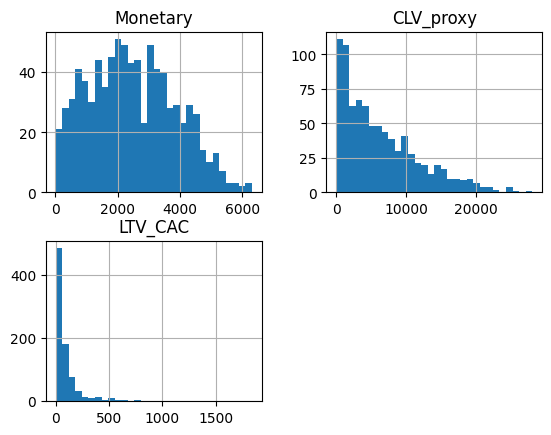

In [ ]:
RFM_CRM[['Monetary', 'CLV_proxy', 'LTV_CAC']].hist(bins=30);

#Apprendimento supervisionato

In [ ]:
RFM_CRM

,CustomerID,Replies,TotalTimeSpent(min),ContactDate,Recency,Frequency,Monetary,AvgPurchaseValue,CLV_proxy,EngagementScore,Acquisition_cost,LTV_CAC,Sostenibile,Tenure
0,1,0.500000,0.759016,2025-06-20,105,0.846154,1047.96,87.330000,1266.165370,0.672837,81.16,15.600855,True,441
1,2,0.083333,0.034290,2025-08-23,41,0.000000,565.59,565.590000,179.749151,0.047049,135.88,1.322852,False,116
2,3,0.166667,0.157514,2024-09-01,397,0.461538,1373.02,196.145714,5890.820055,0.221980,185.16,31.814755,True,1566
3,4,0.250000,0.277049,2025-09-25,8,0.615385,807.99,89.776667,188.162055,0.333897,154.55,1.217483,False,85
4,5,0.166667,0.047131,2025-03-13,204,0.230769,2197.23,549.307500,9589.554493,0.131673,89.31,107.373805,True,1593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,996,0.583333,0.543716,2025-05-03,153,0.923077,1803.67,138.743846,1151.383863,0.635435,101.27,11.369447,True,233
933,997,0.250000,0.516940,2025-06-20,105,0.846154,825.48,68.790000,2098.754630,0.476007,89.18,23.533916,True,928
934,998,0.416667,0.326913,2025-09-12,21,0.846154,18.19,1.515833,35.831808,0.466662,81.13,0.441659,False,719
935,999,0.500000,0.210383,2025-03-12,205,0.461538,871.84,124.548571,3004.862247,0.376461,71.07,42.280319,True,1258


In [ ]:
features = ['Replies', 'Recency', 'Frequency', 'Monetary', 'AvgPurchaseValue', 'CLV_proxy', 'EngagementScore', 'LTV_CAC', 'Tenure']

X = RFM_CRM[features]
y = RFM_CRM['Sostenibile']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

RFM_CRM['Sostenibile'] = le.fit_transform(RFM_CRM['Sostenibile'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=0)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Modelli da confrontare
models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000))
    ]),
    'RandomForest': Pipeline([
        ('rf', RandomForestClassifier(class_weight='balanced'))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, class_weight='balanced'))
    ])
}


In [ ]:
from sklearn.metrics import make_scorer, f1_score, recall_score

# Metriche personalizzate
f1_macro = make_scorer(f1_score, average='macro')
recall_0 = make_scorer(recall_score, pos_label=0)

results = []

for name, pipeline in models.items():
    f1_scores = cross_val_score(pipeline, X, y, cv=5, scoring=f1_macro)
    recall_scores = cross_val_score(pipeline, X, y, cv=5, scoring=recall_0)
    results.append({
        'Modello': name,
        'F1_macro_mean': f1_scores.mean(),
        'Recall_0_mean': recall_scores.mean()
    })

import pandas as pd
results_df = pd.DataFrame(results).sort_values(by='Recall_0_mean', ascending=False)
print(results_df)


              Modello  F1_macro_mean  Recall_0_mean
1        RandomForest       0.994421           1.00
0  LogisticRegression       0.695858           0.94
2                 SVM       0.725075           0.94


In [ ]:
import os
import joblib

model_dir = 'modelli'
model_path = os.path.join(model_dir, 'random_forest_sostenibilita.pkl')
os.makedirs(model_dir, exist_ok=True)

# Se hai una pipeline chiamata pipeline_rf
joblib.dump('RandomForest', model_path)
print(f"Modello salvato correttamente in: {model_path}")


Modello salvato correttamente in: modelli/random_forest_sostenibilita.pkl


In [ ]:
import pandas as pd

def score_clients(df, model, threshold_low=0.3, threshold_high=0.6):

    # Probabilità classe 1 (sostenibile)
    proba = model.predict_proba(df)[:, 1]
    pred_class = model.predict(df)

    # Etichetta strategica
    labels = []
    for p in proba:
        if p >= threshold_high:
            labels.append('Sostenibile')
        elif p <= threshold_low:
            labels.append('Non sostenibile')
        else:
            labels.append('Borderline')

    # Feature importance
    importance = pd.Series(model.feature_importances_, index=df.columns)
    top_features = importance.sort_values(ascending=False).head(5).index.tolist()

    # Output
    result_df = df.copy()
    result_df['Probabilità_sostenibilità'] = proba
    result_df['Classe_predetta'] = pred_class
    result_df['Etichetta_strategica'] = labels
    result_df['Top_features'] = ', '.join(top_features)

    return result_df


#Score

In [ ]:
from sklearn.preprocessing import StandardScaler

def rfm_zscore_scoring(df, rfm_cols=['Recency', 'Frequency', 'Monetary']):
    """
    Normalizza RFM con z-score.
    """
    scaler = StandardScaler()
    df_z = pd.DataFrame(scaler.fit_transform(df[rfm_cols]), columns=[f'{col}_z' for col in rfm_cols], index=df.index)
    return pd.concat([df, df_z], axis=1)


In [ ]:
rfm_zscore_scoring(RFM_CRM, ['Recency', 'Frequency', 'Monetary'])

,CustomerID,Replies,TotalTimeSpent(min),ContactDate,Recency,Frequency,Monetary,AvgPurchaseValue,CLV_proxy,EngagementScore,Acquisition_cost,LTV_CAC,Sostenibile,Tenure,Recency_z,Frequency_z,Monetary_z
0,1,0.500000,0.759016,2025-06-20,105,0.846154,1047.96,87.330000,1266.165370,0.672837,81.16,15.600855,1,441,-0.206159,1.078713,-1.032817
1,2,0.083333,0.034290,2025-08-23,41,0.000000,565.59,565.590000,179.749151,0.047049,135.88,1.322852,0,116,-0.527307,-1.612838,-1.382208
2,3,0.166667,0.157514,2024-09-01,397,0.461538,1373.02,196.145714,5890.820055,0.221980,185.16,31.814755,1,1566,1.259079,-0.144720,-0.797369
3,4,0.250000,0.277049,2025-09-25,8,0.615385,807.99,89.776667,188.162055,0.333897,154.55,1.217483,0,85,-0.692898,0.344653,-1.206633
4,5,0.166667,0.047131,2025-03-13,204,0.230769,2197.23,549.307500,9589.554493,0.131673,89.31,107.373805,1,1593,0.290617,-0.878779,-0.200376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,996,0.583333,0.543716,2025-05-03,153,0.923077,1803.67,138.743846,1151.383863,0.635435,101.27,11.369447,1,233,0.034702,1.323399,-0.485440
933,997,0.250000,0.516940,2025-06-20,105,0.846154,825.48,68.790000,2098.754630,0.476007,89.18,23.533916,1,928,-0.206159,1.078713,-1.193965
934,998,0.416667,0.326913,2025-09-12,21,0.846154,18.19,1.515833,35.831808,0.466662,81.13,0.441659,0,719,-0.627665,1.078713,-1.778702
935,999,0.500000,0.210383,2025-03-12,205,0.461538,871.84,124.548571,3004.862247,0.376461,71.07,42.280319,1,1258,0.295635,-0.144720,-1.160385


#Clustering (KMeans, DBSCAN)

In [ ]:
sc = StandardScaler()
rfmt_sc = sc.fit_transform(RFM_CRM[['Recency', 'Frequency', 'Monetary', 'Tenure']])

##Kmeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfmt_sc)

    sil_score = silhouette_score(rfmt_sc, labels)
    inertia = kmeans.inertia_
    scores.append({'k': k, 'silhouette': sil_score, 'inertia': inertia})

import pandas as pd
score_df = pd.DataFrame(scores)
print(score_df.sort_values(by='silhouette', ascending=False))


   k  silhouette      inertia
3  5    0.243540  1491.172530
7  9    0.237573  1019.630463
5  7    0.237346  1203.261523
6  8    0.233260  1100.657141
1  3    0.231814  2100.219775
4  6    0.229584  1342.180704
2  4    0.222108  1775.310708
0  2    0.205517  2729.316757


##DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.2, min_samples=5)
db_labels = dbscan.fit_predict(rfmt_sc)

# Solo se > 1 cluster
if len(set(db_labels)) > 1:
    sil_db = silhouette_score(rfmt_sc, db_labels)
    print(f"Silhouette DBSCAN: {sil_db:.3f}")
else:
    print("DBSCAN ha trovato solo un cluster o rumore.")


Silhouette DBSCAN: 0.508


In [ ]:
RFM_CRM['Cluster'] = kmeans.labels_  # o db_labels

cluster_map = {
    0: 'Champions',
    1: 'Loyal',
    2: 'Dormant',
    3: 'At Risk',
    4: 'New',
    5: 'Potential',
    6: 'Need Attention',
    7: 'Lost',
    8: 'Unclassified'
}

RFM_CRM['Segmento'] = RFM_CRM['Cluster'].map(cluster_map)


In [ ]:
RFM_CRM

,CustomerID,Replies,TotalTimeSpent(min),ContactDate,Recency,Frequency,Monetary,AvgPurchaseValue,CLV_proxy,EngagementScore,Acquisition_cost,LTV_CAC,Sostenibile,Tenure,Cluster,Segmento
0,1,0.500000,0.759016,2025-06-20,105,0.846154,1047.96,87.330000,1266.165370,0.672837,81.16,15.600855,1,441,2,Dormant
1,2,0.083333,0.034290,2025-08-23,41,0.000000,565.59,565.590000,179.749151,0.047049,135.88,1.322852,0,116,6,Need Attention
2,3,0.166667,0.157514,2024-09-01,397,0.461538,1373.02,196.145714,5890.820055,0.221980,185.16,31.814755,1,1566,1,Loyal
3,4,0.250000,0.277049,2025-09-25,8,0.615385,807.99,89.776667,188.162055,0.333897,154.55,1.217483,0,85,2,Dormant
4,5,0.166667,0.047131,2025-03-13,204,0.230769,2197.23,549.307500,9589.554493,0.131673,89.31,107.373805,1,1593,1,Loyal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,996,0.583333,0.543716,2025-05-03,153,0.923077,1803.67,138.743846,1151.383863,0.635435,101.27,11.369447,1,233,2,Dormant
933,997,0.250000,0.516940,2025-06-20,105,0.846154,825.48,68.790000,2098.754630,0.476007,89.18,23.533916,1,928,7,Lost
934,998,0.416667,0.326913,2025-09-12,21,0.846154,18.19,1.515833,35.831808,0.466662,81.13,0.441659,0,719,2,Dormant
935,999,0.500000,0.210383,2025-03-12,205,0.461538,871.84,124.548571,3004.862247,0.376461,71.07,42.280319,1,1258,1,Loyal


In [ ]:
def segment_kpi_summary(df):
    """
    Restituisce una tabella aggregata con KPI strategici per ciascun segmento CRM.
    """
    return df.groupby('Segmento').agg({
        'Recency': ['mean'],
        'Frequency': ['mean'],
        'Monetary': ['mean'],
        'Tenure': ['mean'],
        'EngagementScore': ['mean'],
        'LTV_CAC': ['mean'],
        'CustomerID': 'count'  # volume clienti per segmento
    }).round(2)

segment_kpi_summary(RFM_CRM)

,Recency,Frequency,Monetary,Tenure,EngagementScore,LTV_CAC,CustomerID
,mean,mean,mean,mean,mean,mean,count
Segmento,,,,,,,
At Risk,130.08,0.31,3932.20,1445.92,0.22,240.13,77
Champions,73.36,0.36,3903.06,441.54,0.24,69.45,104
Dormant,60.91,0.85,1963.69,385.68,0.55,27.05,124
Lost,68.74,0.75,1575.98,1310.50,0.50,80.14,132
Loyal,189.37,0.22,1373.56,1432.44,0.17,79.73,95
Need Attention,94.05,0.30,1298.77,563.02,0.23,36.15,115
New,437.51,0.21,2597.02,515.08,0.15,62.54,53
Potential,78.95,0.83,3757.98,1279.06,0.57,217.67,110


/tmp/ipython-input-1686049951.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


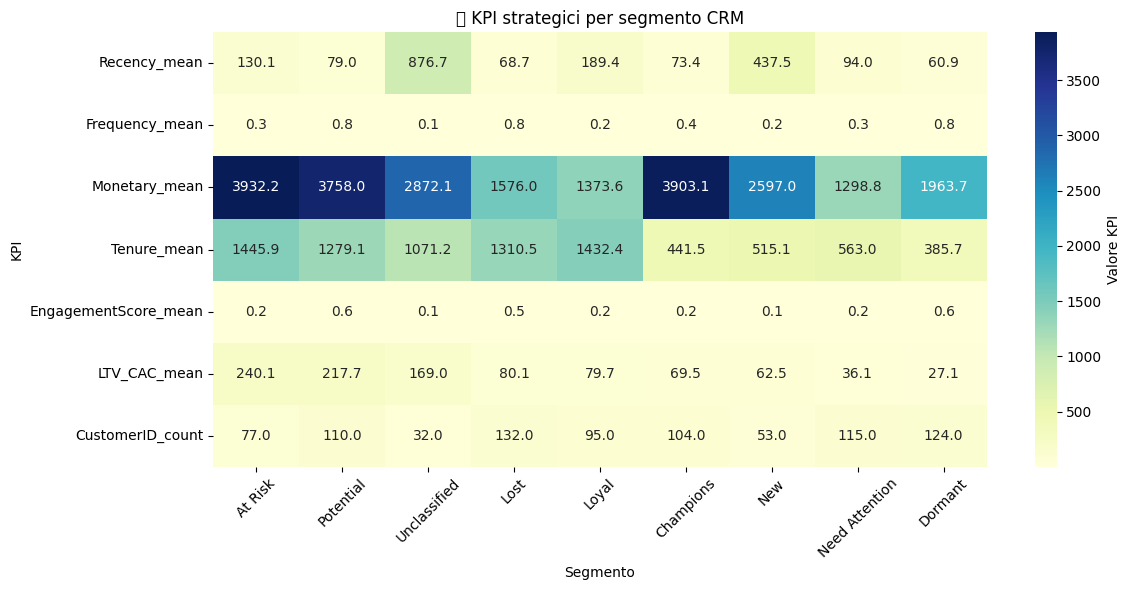

In [ ]:
kpi_df = RFM_CRM.groupby('Segmento').agg({
    'Recency': ['mean'],
        'Frequency': ['mean'],
        'Monetary': ['mean'],
        'Tenure': ['mean'],
        'EngagementScore': ['mean'],
        'LTV_CAC': ['mean'],
        'CustomerID': 'count'
}).round(2)
# Rinomina le colonne con nome_metriche
kpi_df.columns = ['_'.join(col).strip() for col in kpi_df.columns.values]
kpi_df = kpi_df.sort_values(by='LTV_CAC_mean', ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns
# Crea la heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(kpi_df.T, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Valore KPI'})
plt.title("📊 KPI strategici per segmento CRM")
plt.ylabel("KPI")
plt.xlabel("Segmento")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#4. Churn & Retention

In [ ]:
RFM_CRM['LeadStatus'] = df_customers['LeadStatus']

In [ ]:
RFM_CRM['AcquisitionChannel'] = df_customers['AcquisitionChannel']

In [ ]:
def analyze_churn_patterns(RFM_CRM, recency_thresh=365, tenure_thresh=180, engagement_thresh=1.5):
    """
    Analizza il churn e i pattern di abbandono per segmento e canale.
    """
    # 1. Regole di churn
    RFM_CRM['Churn'] = (
        (RFM_CRM['Recency'] > recency_thresh) |
        (RFM_CRM['Tenure'] < tenure_thresh) |
        (RFM_CRM['LeadStatus'].str.lower() == 'perso') |
        (RFM_CRM['EngagementScore'] < engagement_thresh)
    ).astype(int)

    # 2. Churn rate per segmento
    churn_by_segment = RFM_CRM.groupby('Segmento')['Churn'].mean().round(2)

    # 3. Pattern abbandono per canale
    churned = RFM_CRM[RFM_CRM['Churn'] == 1]
    churn_patterns = churned.groupby('AcquisitionChannel').agg({
        'EngagementScore': 'mean',
        'Monetary': 'mean',
        'Tenure': 'mean',
        'Recency': 'mean',
        'Frequency': 'mean',
        'LeadStatus': lambda x: x.value_counts().idxmax()
    }).round(1)

    return churn_by_segment, churn_patterns


In [ ]:
churn_segment, churn_patterns = analyze_churn_patterns(RFM_CRM)

print("Churn rate per segmento:")
print(churn_segment)

print("\nPattern di abbandono per canale di acquisizione:")
print(churn_patterns)


Churn rate per segmento:
Segmento
At Risk           1.0
Champions         1.0
Dormant           1.0
Lost              1.0
Loyal             1.0
Need Attention    1.0
New               1.0
Potential         1.0
Unclassified      1.0
Name: Churn, dtype: float64

Pattern di abbandono per canale di acquisizione:
                    EngagementScore  Monetary  Tenure  Recency  Frequency  \
AcquisitionChannel                                                          
Ads                             0.3    2462.7   932.6    153.7        0.5   
Direct                          0.4    2504.8   944.4    153.6        0.5   
Referral                        0.4    2590.3   961.3    127.8        0.5   
SEO                             0.3    2428.1   906.7    165.9        0.5   
Social                          0.4    2384.3   893.9    128.1        0.5   

                     LeadStatus  
AcquisitionChannel               
Ads                       Nuovo  
Direct              Qualificato  
Referral      

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def summarize_segments(df):
    """
    Aggrega KPI strategici per segmento CRM e visualizza:
    - Heatmap dei KPI
    - Scatterplot Valore vs Rischio
    - Barre LTV/CAC
    """
    # Aggregazione KPI
    kpi_df = df.groupby('Segmento').agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean',
        'Tenure': 'mean',
        'EngagementScore': 'mean',
        'LTV_CAC': 'mean',
        'CustomerID': 'count'
        }).rename(columns={'CustomerID': 'CustomerCount'}).round(1)


    # Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(kpi_df.T, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Valore KPI'})
    plt.title("📊 KPI strategici per segmento CRM")
    plt.ylabel("KPI")
    plt.xlabel("Segmento")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Scatterplot Valore vs Rischio
    plt.figure(figsize=(10, 6))
    plt.scatter(kpi_df['Recency'], kpi_df['LTV_CAC'], s=kpi_df['CustomerCount']*10, alpha=0.7)
    for i, label in enumerate(kpi_df.index):
        plt.text(kpi_df['Recency'][i]+1, kpi_df['LTV_CAC'][i], label, fontsize=9)
    plt.xlabel("Recency media (rischio abbandono)")
    plt.ylabel("LTV/CAC medio (valore strategico)")
    plt.title("🎯 Matrice Valore vs Rischio per Segmento CRM")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Barre LTV/CAC
    kpi_df['LTV_CAC'].sort_values().plot(kind='barh', figsize=(8, 5), color='teal')
    plt.title("💰 Redditività (LTV/CAC) per Segment")
    plt.xlabel("LTV / CAC")
    plt.ylabel("Segmento")
    plt.tight_layout()
    plt.show()

    return kpi_df


/tmp/ipython-input-2250905779.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


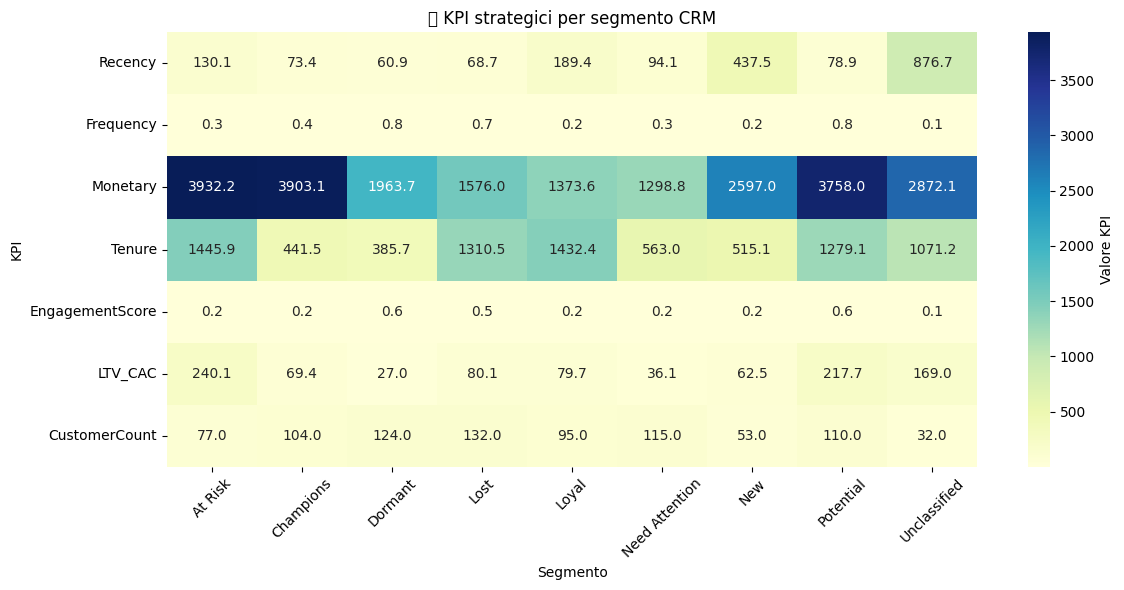

/tmp/ipython-input-2250905779.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(kpi_df['Recency'][i]+1, kpi_df['LTV_CAC'][i], label, fontsize=9)
/tmp/ipython-input-2250905779.py:42: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


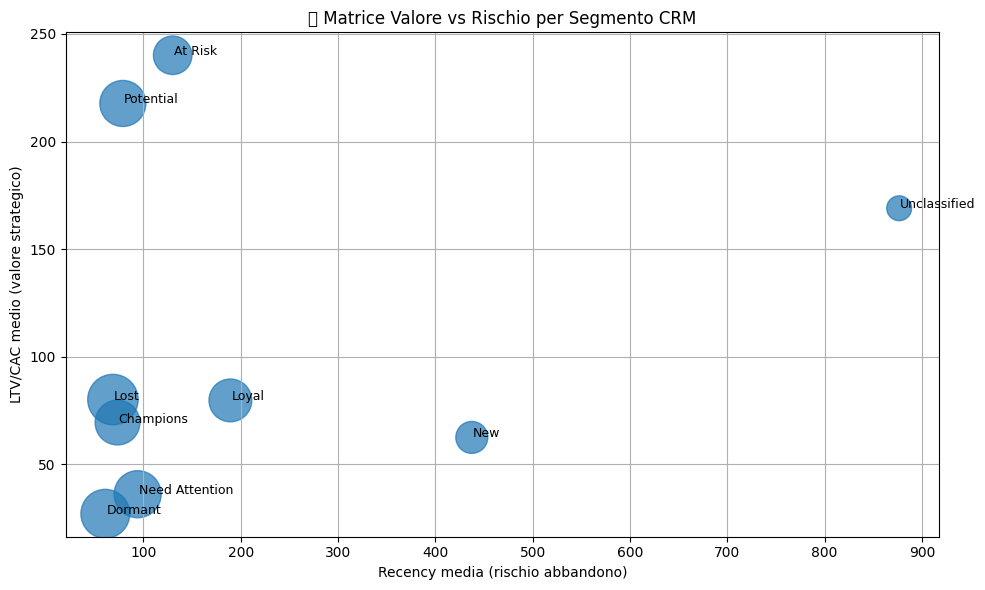

/tmp/ipython-input-2250905779.py:50: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


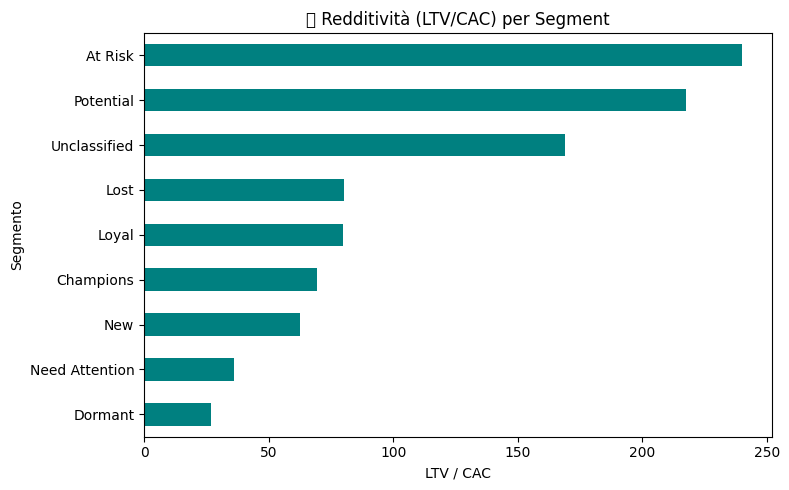

,Recency,Frequency,Monetary,Tenure,EngagementScore,LTV_CAC,CustomerCount
Segmento,,,,,,,
At Risk,130.1,0.3,3932.2,1445.9,0.2,240.1,77
Champions,73.4,0.4,3903.1,441.5,0.2,69.4,104
Dormant,60.9,0.8,1963.7,385.7,0.6,27.0,124
Lost,68.7,0.7,1576.0,1310.5,0.5,80.1,132
Loyal,189.4,0.2,1373.6,1432.4,0.2,79.7,95
Need Attention,94.1,0.3,1298.8,563.0,0.2,36.1,115
New,437.5,0.2,2597.0,515.1,0.2,62.5,53
Potential,78.9,0.8,3758.0,1279.1,0.6,217.7,110
Unclassified,876.7,0.1,2872.1,1071.2,0.1,169.0,32


In [ ]:
summarize_segments(RFM_CRM)

In [ ]:
RFM_CRM['Churn'].value_counts()

,count
Churn,
1,842


##Download

In [ ]:
RFM_CRM.to_csv('KPIs.csv')
df_customers.to_csv('customers.csv')
df_interactions.to_csv('interactions.csv')
df_purchases.to_csv('purchase.csv')
segment_kpi_summary.to_csv('kpi_summary.csv')